In [1]:
import torch.nn.functional as F
from torch.nn.functional import interpolate
import torch.nn as nn
import torchvision
import torch

import sys
sys.path.append('../')
import os
import glob
import pandas as pd
import argparse
import configparser
import numpy as np
import torch
import matplotlib
matplotlib.use( 'tkagg' )
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

from model import *
#from lib.preprocessing.single_transforms import get_transformer_norm
from lib.preprocessing import single_transforms
from lib.dataloading import *
from lib.loss_functions import *
from lib.evaluation import *
from torchvision import transforms
import torchvision.models as models
from torch import optim, nn
import torch.nn.functional as F


In [23]:
res = models.resnet50(pretrained=False)
res = list(res.children())[:-2]
res = nn.Sequential(*res)

In [24]:
res

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [2]:
class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)                
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        b, c, w, h = x.size()
        
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=False)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        print(x.size())
        x = self.input_block(x)
        print(x.size())
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)
        print(x.size())

        for i, block in enumerate(self.down_blocks, 2):
            print(x.size())
            x = block(x)
            print(x.size())
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [3]:
resunet = UNetWithResnet50Encoder()

In [15]:
transform = single_transforms.get_transformer_norm(resize = (256,384))
dataset = SSIDataset(img_file = '../data/ssi.csv', transform= transform['val'], inpaint = True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1)
dataiter = iter(dataloader)

In [16]:
img, center, label = next(dataiter)

In [17]:
img.size()

torch.Size([1, 3, 256, 384])

In [26]:
out = res(img)
out.size()

torch.Size([1, 2048, 8, 12])

In [29]:
out = vgg(img)
out.size()

torch.Size([1, 512, 8, 12])

In [22]:
out.size()

torch.Size([1, 512, 8, 12])

In [7]:
out = resunet(img)

torch.Size([1, 3, 256, 384])
torch.Size([1, 64, 128, 192])
torch.Size([1, 64, 64, 96])
torch.Size([1, 64, 64, 96])
torch.Size([1, 256, 64, 96])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 1024, 16, 24])
torch.Size([1, 1024, 16, 24])
torch.Size([1, 2048, 8, 12])


In [8]:
nt_dataset = SSIDataset(img_file = '../data/ssi.csv', inpaint = False)

In [44]:
img = nt_dataset[0]

In [56]:
256/384

0.6666666666666666

In [48]:
for i in range(100):
    img = nt_dataset[i]
    print(img.shape[0]/img.shape[1])

0.7520833333333333
0.7520833333333333
1.0443548387096775
1.0443548387096775
1.0443548387096775
0.6229166666666667
1.0443548387096775
0.6229166666666667
0.6229166666666667
0.59375


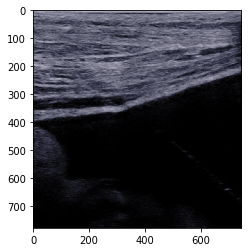

In [54]:
%matplotlib inline
plt.imshow(nt_dataset[3])